## Code to use a RF to classify summer and evergreen pixels in a Sentinel-2 image

In [3]:
#only needed if you use colab
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Load and install libraries

In [4]:
!pip install rasterio
!pip install geopandas
!pip install -U statsmodels
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from pathlib import Path
import os
from sklearn.feature_selection import SelectFromModel
import joblib
# If you're working in Jupyter Notebook, include the following so that plots will display:
%matplotlib inline

## Load the trained RF in the season you want to use

In [35]:
# Load the trained network here I load the late summer season with the masked out non
#forests
RF = joblib.load('add path to the trained RF')

In [37]:
# load the Sentinel-2 image that you want to predict on
# Here I am using the LS image from the Yakutsk region
from rasterio.plot import reshape_as_image

# File path to the image
S2_image = 'add path to the S2 image'

# Open the image file
with rasterio.open(S2_image) as src:
    # Reading the image
    S2_image = src.read()



In [40]:
# Reshape the image for further processing
reshaped_S2 = reshape_as_image(S2_image)

forest_classification = RF.predict(reshaped_S2.reshape(-1, 11))

# Reshape our classification map back into a 2D matrix so we can visualize it
forest_classification = forest_classification.reshape(reshaped_S2[:, :, 0].shape)
uniqueValues = np.unique(forest_classification)

# Check the classes and number of pixels predicted
np.unique(forest_classification, return_counts=True)

(array([1., 2., 9.]), array([2071354, 2322875, 2548371]))

## Visualize the classified map

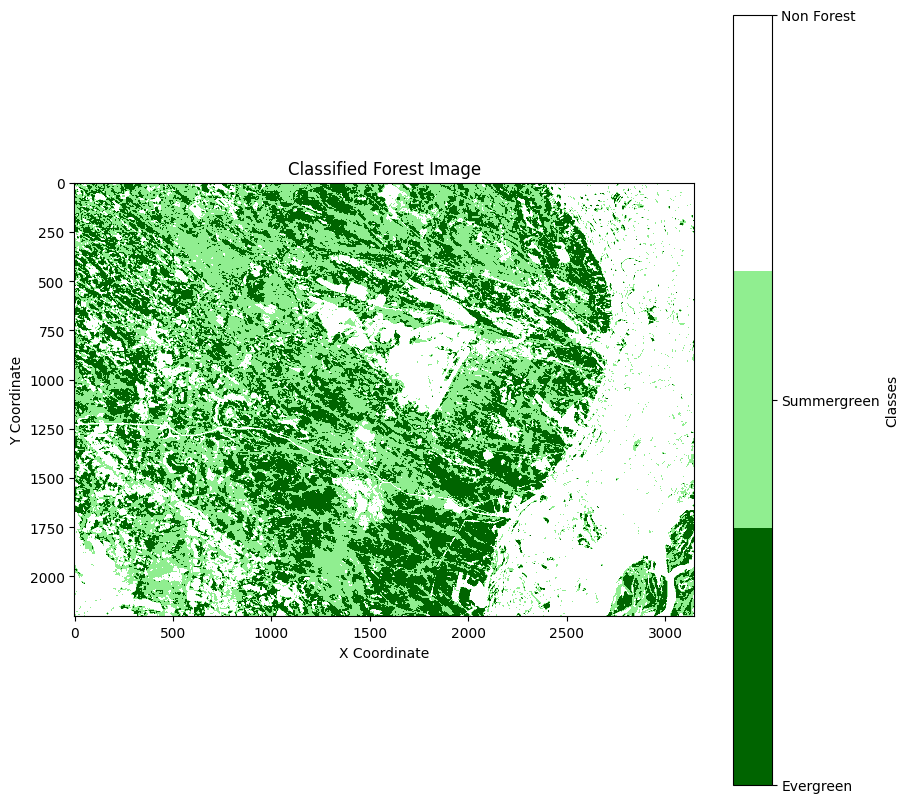

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Convert all labels 9 to label 3 for masking
forest_classification = np.where(forest_classification == 9, 3, forest_classification)

# Define colormap colors
class_colors = {
    1: (0, 100, 0, 255),     # Dark Green - Evergreen
    2: (144, 238, 144, 255),  # Light Green - Summergreen
    3: (255, 255, 255, 255)  # Mask - Non Forest, below 0.7 threshold
}

# Normalize colors to [0, 1] range
for key, rgba in class_colors.items():
    class_colors[key] = [channel / 255.0 for channel in rgba]

# Find the highest class value in the prediction array
max_class_value = int(np.max(forest_classification))

# Create colormap index list without an entry for 0 (missing values)
color_list = [class_colors[key] if key in class_colors else (1, 1, 1, 0) for key in range(1, max_class_value + 1)]

# Create the colormap
classification_cmap = ListedColormap(color_list, name='ForestClassification', N=max_class_value)

# Mask the zero values
masked_forest_classification = np.ma.masked_equal(forest_classification, 0)

# Plot the classified image
plt.figure(figsize=(10, 10))
image = plt.imshow(masked_forest_classification, cmap=classification_cmap)
colorbar = plt.colorbar(image, ticks=range(1, max_class_value + 1))
colorbar.ax.set_yticklabels(['Evergreen', 'Summergreen', 'Non Forest'])  # Set class labels
colorbar.set_label('Classes')
plt.title('Classified Forest Image')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()



In [ ]:
# if needed: save classified image
import rasterio as rio

with rio.open(S2_image) as src:
    ras_data = src.read()
    ras_meta = src.profile

with rio.open('name_your_file', 'w', **ras_meta) as dst:
    dst.write(forest_classification, 1)